In [1]:
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from utils.write import training_data, test_data, glove

In [2]:
# run params
SECTION = 'write'
RUN_ID = '0002'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))

mode = 'build'  # 'load'

In [3]:
training_data_gen = training_data()
test_data_gen = test_data()

t = next(training_data_gen)
idx = 0

print('document_tokens\n', t['document_tokens'][idx])
print('\n')
print('question_input_tokens\n', t['question_input_tokens'][idx])
print('\n')
print('answer_masks\n', t['answer_masks'][idx])
print('\n')
print('answer_labels\n', t['answer_labels'][idx])
print('\n')
print('question_output_tokens\n', t['question_output_tokens'][idx])


document_tokens
 [ 793  925    5  627    1 4601    1   66 2195 2075 1036   32 1363   11
  809   20   27 5851    5 9586    5   50  836   36 1435   98  103   13
 2583 9234   72    5   11 1166  382    8    4  383   12 1913    5    1
 4446 3251    5   19  184    6   11  402 1913  210 9586 1363   11    1
   20 2075 1036    5   39   17  872    7 9234   72    6    4 1166    5
   39  119   37 3392    8   31  563  113   68   18   37 4517    8 2171
   16    4 1113    5  119   37   34  130  488 1118   29  192 1052 1417
   67    8  150 2075    9 9586   13  102   32 1563   10    4  340    5
   28 4446 3251   19   10   11  373    6   29   40   33  150  352 2074
    8  161   20    5    9   42 3392  101  143    6   28    4  793  925
    5  627    5  376 1215 1435   56 8162 4235   98 1036    5  899    5
   77  147 6547    8   11  616  651 1565   10   43  142   19   21 8628
 9586    5  947    6   11  142  373   19    4 1565  308   62 9586    5
  506  548  310   17    1 9586    1    5  237   11 2784 1428

In [4]:
# GloVe
VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

print('GLOVE')
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('EMBEDDING_DIMENS: ', EMBEDDING_DIMENS)

GLOVE
VOCAB_SIZE:  9984
EMBEDDING_DIMENS:  100


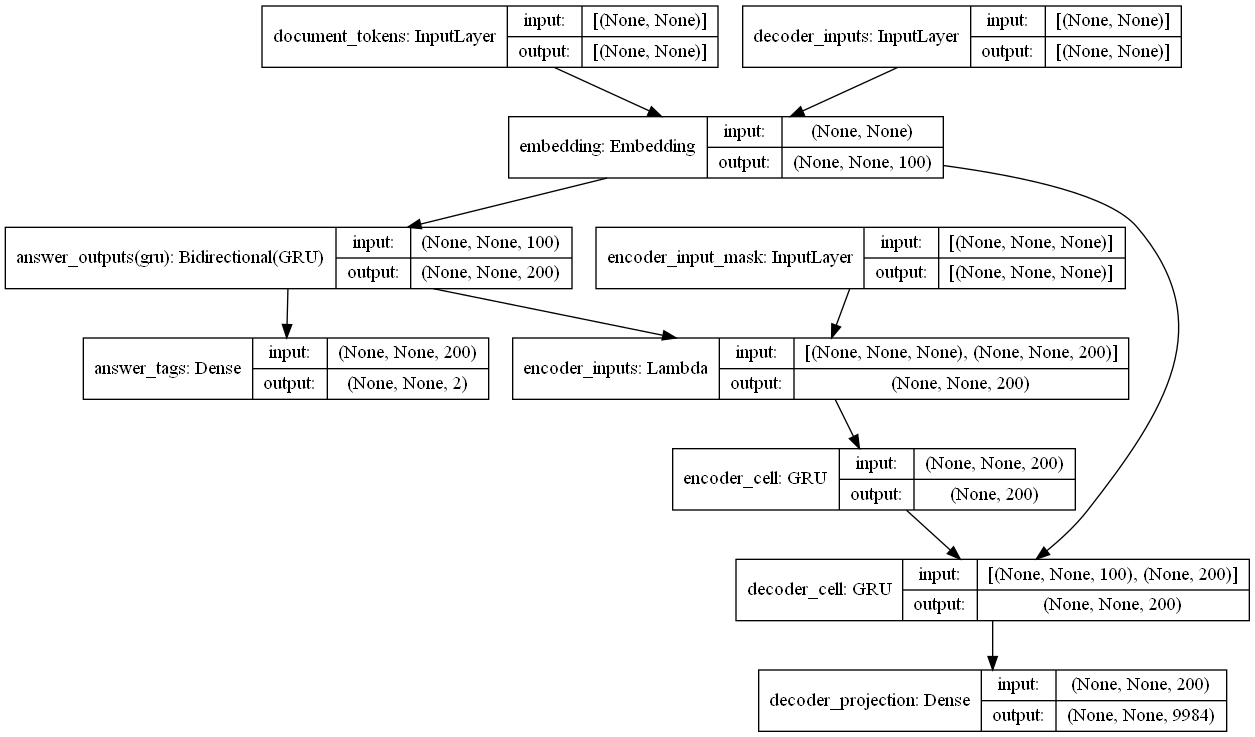

(None, None, 100)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_tokens (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    998400      document_tokens[0][0]            
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
answer_outputs (Bidirectional)  (None, None, 200)    121200      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_input_mask (InputLayer) [(None, None, None)] 0                      

In [5]:
GRU_UNITS = 100
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

document_tokens = keras.Input(shape=(MAX_DOC_SIZE,), name='document_tokens')

embedding = keras.layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIMENS,
    weights=[glove],
    mask_zero=True,
    name='embedding'
)
document_emb = embedding(document_tokens)

answer_outputs = keras.layers.Bidirectional(
    keras.layers.GRU(GRU_UNITS, return_sequences=True),
    name='answer_outputs'
)(document_emb)
answer_tags = keras.layers.Dense(
    2, activation='softmax',
    name='answer_tags'
)(answer_outputs)

encoder_input_mask = keras.Input(
    shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE),
    name='encoder_input_mask'
)
encoder_inputs = keras.layers.Lambda(
    lambda x: tf.matmul(x[0], x[1]),
    name="encoder_inputs"
)([encoder_input_mask, answer_outputs])
encoder_cell = keras.layers.GRU(
    2 * GRU_UNITS, name='encoder_cell'
)(encoder_inputs)

decoder_inputs = keras.Input(shape=(MAX_Q_SIZE,), name='decoder_inputs')
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = keras.layers.GRU(
    2 * GRU_UNITS,
    return_sequences=True,
    name='decoder_cell'
)
decoder_states = decoder_cell(decoder_emb, initial_state=[encoder_cell])

decoder_projection = keras.layers.Dense(
    VOCAB_SIZE, name='decoder_projection',
    activation='softmax', use_bias=False
)
decoder_outputs = decoder_projection(decoder_states)

total_model = keras.Model([document_tokens, decoder_inputs, encoder_input_mask],
                          [answer_tags, decoder_outputs])
keras.utils.plot_model(total_model, to_file='model.png', show_shapes=True)

print(decoder_emb.shape)
total_model.summary()

In [ ]:
#### COMPILE TRAINING MODEL ####
opti = keras.optimizers.Adam(lr=0.001)
total_model.compile(loss=['sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
                    optimizer=opti, loss_weights=[1, 1])


In [ ]:
training_loss_history = []
test_loss_history = []

EPOCHS = 1000
SAVE_EVERY_N_EPOCH = 100
start_epoch = 1

for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("Epoch {0}".format(epoch))

    for i, batch in enumerate(training_data()):
        val_batch = next(test_data_gen, None)

        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)

        training_loss = total_model.train_on_batch(
            [batch['document_tokens'], batch['question_input_tokens'], batch['answer_masks']],
            [np.expand_dims(batch['answer_labels'], axis=-1), np.expand_dims(batch['question_output_tokens'], axis=-1)]
        )

        test_loss = total_model.test_on_batch(
            [val_batch['document_tokens'], val_batch['question_input_tokens'], val_batch['answer_masks']],
            [np.expand_dims(val_batch['answer_labels'], axis=-1), np.expand_dims(val_batch['question_output_tokens'], axis=-1)]
        )

        training_loss_history.append(training_loss)
        test_loss_history.append(test_loss)

        print("{}: Train Loss: {} | Test Loss: {}".format(
            i, training_loss, test_loss))

    if epoch % SAVE_EVERY_N_EPOCH == 0:
        total_model.save_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(epoch)))

In [ ]:
#### SHOW LOSSES ####
plt.plot(np.array(training_loss_history)[:,0])
plt.plot(np.array(test_loss_history)[:,0])
plt.savefig(os.path.join(RUN_FOLDER, 'images/loss.png'))
plt.show()
        
pkl.dump([training_loss_history, test_loss_history], open(os.path.join(RUN_FOLDER, 'weights/histories.pkl'), 'wb'))